In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import string
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from torch.utils.data import Dataset, DataLoader
import json

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: Tesla V100-PCIE-32GB , device num:0


# Preparing data

In [3]:
char2index = {'sos': 0, 'eos': 1, 'pad': 2, **{char: i + 3 for i, char in enumerate(string.ascii_lowercase)}}
index2char = {i: char for char, i in char2index.items()}

In [4]:
class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split = 'train', padding = 21):
        super(SpellCorrectionDataset, self).__init__()
        self.data, self.targets = self.load_data(root, split)
        self.padding = padding

    def load_data(self, root, split):
        file_path = f"{root}/{split}.json"
        with open(file_path, 'r') as file:
            data = json.load(file)
        input_list, target_list = [], []
        for item in data:
            input_list.extend(item['input'])
            target_list.extend([item['target']] * len(item['input']))
            
        return input_list, target_list

    def tokenize(self, text):
        return [char2index.get(char, char2index['pad']) for char in text]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_text = self.data[index]
        target_text = self.targets[index]
        input_ids = [char2index['sos']] + self.tokenize(input_text) + [char2index['eos']] + [char2index['pad']] * (self.padding - len(input_text) - 2)
        target_ids = [char2index['sos']] + self.tokenize(target_text) + [char2index['eos']] + [char2index['pad']] * (self.padding - len(target_text) - 2)
        return torch.tensor(input_ids, dtype = torch.long), torch.tensor(target_ids, dtype = torch.long)

In [5]:
root_path = '../data/'
trainset = SpellCorrectionDataset(root_path, split = 'train')
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)
valset = SpellCorrectionDataset(root_path, split = 'test')
valloader = DataLoader(valset, batch_size = 16, shuffle = False)
testset = SpellCorrectionDataset(root_path, split = 'new_test')
testloader = DataLoader(testset, batch_size = 16, shuffle = False)

# Building the model

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers = 2, dropout = 0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hid_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers = 2, dropout = 0.5)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        d_output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(d_output.squeeze(0))
        return prediction, hidden

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        src = torch.transpose(src,0,1)
        trg = torch.transpose(trg,0,1)
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        output, hidden = self.encoder(src)

        input = trg[0,:]

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            input = trg[t] if use_teacher_forcing else output.argmax(1)
        outputs_T = torch.transpose(outputs, 0, 1)
        return outputs_T

# Training the model

In [10]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

In [11]:
def train(model, trainloader, optimizer, criterion, clip):

    model.train().to(device)

    epoch_loss = 0

    for i, data in enumerate(trainloader):

        src = data[0].to(device)
        trg = data[1].to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(trainloader)

In [13]:
def output_i2c(index):
    i2c = []
    for k in range(index.shape[0]):
        softmax_tensor = F.softmax(index[k].float(), dim = 1)
        argmax_indices = torch.argmax(softmax_tensor , dim = 1)
        l = argmax_indices.tolist()
        ll = [item for item in l if item not in [0, 1, 2]]
        l_c = [index2char[char] for char in ll]
        c = ''.join(l_c)
        i2c.append(c)
    return i2c

def index_to_char(index):
    i2c = []
    for k in range(index.shape[0]):
        l = index[k].tolist()
        ll = [item for item in l if item not in [0, 1, 2]]
        l_c = [index2char[char] for char in ll]
        c = ''.join(l_c)
        i2c.append(c)
    return i2c

In [14]:
def evaluate(model, valloader, criterion, logout = False):
    model.eval()
    epoch_loss = 0
    bleu_score = []
    acc = 0

    with torch.no_grad():
        for i, data in enumerate(valloader):
            src, trg = data[0].to(device) , data[1].to(device)
            output = model(src ,trg , 0)
            output_dim = output.shape[-1]
            src_c = index_to_char(src)
            trg_c = index_to_char(trg)
            output_c = output_i2c(output)
            for k in range(len(src_c)):
                bleu_score.append(compute_bleu(output_c[k], trg_c[k]))
                if trg_c[k] == output_c[k]:
                    acc += 1
                if logout:
                    print('=' * 20)
                    print('input: ', src_c[k])
                    print('target:', trg_c[k])
                    print('pred:  ', output_c[k])
            output = output[:, 1:, :].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return acc / 50, np.mean(bleu_score), epoch_loss / len(valloader)

In [15]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
vocab_size = 29
emb_dim = 256
hidden_size = 512

enc = EncoderRNN(vocab_size, hidden_size)
dec = DecoderRNN(hidden_size, vocab_size)

model = Seq2Seq(enc, dec, device).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 80, 110, 140], gamma = 0.5)
criterion = nn.CrossEntropyLoss(ignore_index = 2)

In [18]:
train_losses, val_losses, test_losses = [], [], []
val_bleus, test_bleus = [], []
val_accs, test_accs = [], []
best_val_acc = 0.0
best_test_acc = 0.0
best_avg_acc = 0.0

In [19]:
N_EPOCHS = 150
CLIP = 1

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, trainloader, optimizer, criterion, CLIP)
    val_acc, val_bleu, valid_loss = evaluate(model, valloader, criterion, logout = False)
    test_acc, test_bleu, test_loss = evaluate(model, testloader, criterion, logout = False)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    test_losses.append(test_loss)
    val_bleus.append(val_bleu)
    test_bleus.append(test_bleu)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    metrics = {
        'epoch': epoch + 1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'val_bleus': val_bleus,
        'test_bleus': test_bleus,
        'val_accs': val_accs,
        'test_accs': test_accs
    }
    torch.save(metrics, 'all_metrics.pth')
    torch.save(model.state_dict(), 'latest-model.pth')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best-model-val-acc.pth')

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best-model-test-acc.pth')

    avg_acc = (val_acc + test_acc) / 2
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        torch.save(model.state_dict(), 'best-model-avg-acc.pth')
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step()
    
    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Val. BLEU: {val_bleu:.3f} |  Val. Acc: {val_acc*100:6.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f}')
    print(f'\t Test BLEU: {test_bleu:.3f} |  Test Acc: {test_acc*100:6.2f}%')

Epoch: 01 | Time: 0m 33s
	Train Loss: 2.725 | Train PPL:  15.260
	 Val. Loss: 2.812 |  Val. PPL:  16.637
	 Val. BLEU: 0.064 |  Val. Acc:   0.00%
	 Test Loss: 2.748 |  Test PPL:  15.618
	 Test BLEU: 0.051 |  Test Acc:   0.00%
Epoch: 02 | Time: 0m 32s
	Train Loss: 2.516 | Train PPL:  12.373
	 Val. Loss: 2.709 |  Val. PPL:  15.007
	 Val. BLEU: 0.065 |  Val. Acc:   0.00%
	 Test Loss: 2.657 |  Test PPL:  14.253
	 Test BLEU: 0.057 |  Test Acc:   0.00%
Epoch: 03 | Time: 0m 32s
	Train Loss: 2.417 | Train PPL:  11.213
	 Val. Loss: 2.842 |  Val. PPL:  17.156
	 Val. BLEU: 0.078 |  Val. Acc:   0.00%
	 Test Loss: 2.712 |  Test PPL:  15.066
	 Test BLEU: 0.062 |  Test Acc:   0.00%
Epoch: 04 | Time: 0m 33s
	Train Loss: 2.337 | Train PPL:  10.351
	 Val. Loss: 2.735 |  Val. PPL:  15.416
	 Val. BLEU: 0.059 |  Val. Acc:   0.00%
	 Test Loss: 2.532 |  Test PPL:  12.578
	 Test BLEU: 0.065 |  Test Acc:   0.00%
Epoch: 05 | Time: 0m 32s
	Train Loss: 2.138 | Train PPL:   8.480
	 Val. Loss: 2.456 |  Val. PPL:  11

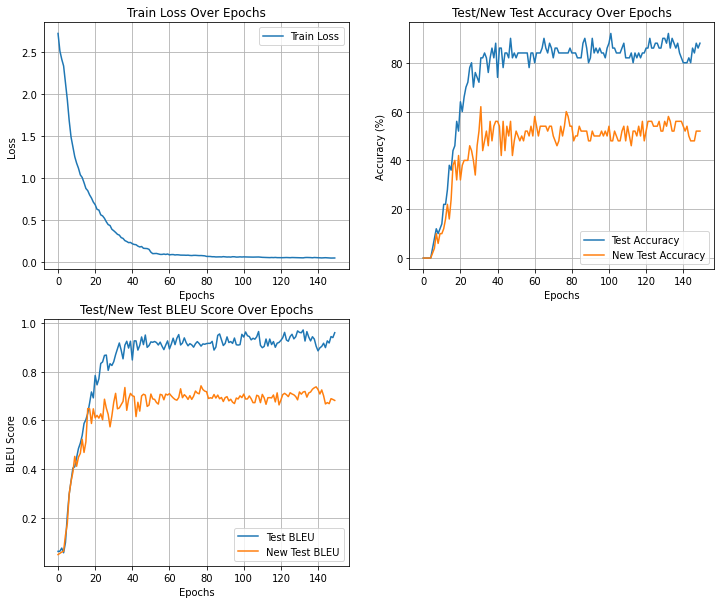

In [20]:
%matplotlib inline

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot([acc * 100 for acc in val_accs], label='Test Accuracy')
plt.plot([acc * 100 for acc in test_accs], label='New Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test/New Test Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(val_bleus, label='Test BLEU')
plt.plot(test_bleus, label='New Test BLEU')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Test/New Test BLEU Score Over Epochs')
plt.legend()
plt.grid()

plt.savefig('pic_all.png')
plt.show()

In [22]:
val_acc, val_bleu, valid_loss = evaluate(model, valloader, criterion, logout = True)
print(f'Bleu-4 score: {val_bleu: .4f}, Accuracy: {val_acc: .4f}')

input:  contenpted
target: contented
pred:   contentedd
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problam
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   poetry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  stanerdizing
target: standardizing
pred:   st

In [23]:
test_acc, test_bleu, test_loss = evaluate(model, testloader, criterion, logout = True)
print(f'Bleu-4 score: {test_bleu: .4f}, Accuracy: {test_acc: .4f}')

input:  apreciate
target: appreciate
pred:   appreciate
input:  appeciate
target: appreciate
pred:   appreciate
input:  apprciate
target: appreciate
pred:   approximate
input:  apprecate
target: appreciate
pred:   appreciate
input:  apprecite
target: appreciate
pred:   appreciate
input:  luve
target: love
pred:   love
input:  culd
target: cold
pred:   chold
input:  heart
target: heart
pred:   heart
input:  televiseon
target: television
pred:   television
input:  thone
target: phone
pred:   phone
input:  phace
target: phase
pred:   patach
input:  poam
target: poem
pred:   poem
input:  tomorraw
target: tomorrow
pred:   tomorrow
input:  presishan
target: precision
pred:   precision
input:  presishion
target: precision
pred:   precision
input:  presisian
target: precision
pred:   presission
input:  presistion
target: precision
pred:   presistion
input:  perver
target: prefer
pred:   prever
input:  predgudice
target: prejudice
pred:   preductice
input:  predgudis
target: prejudice
pred:   p

In [24]:
model.load_state_dict(torch.load('latest-model.pth'))

<All keys matched successfully>

In [19]:
m = torch.load('all_metrics.pth')
epoch = m['epoch']
train_losses = m['train_losses']
val_losses = m['val_losses']
test_losses = m['test_losses']
val_bleus = m['val_bleus']
test_bleus = m['test_bleus']
val_accs = m['val_accs']
test_accs = m['test_accs']

In [27]:
# 平均準確率最高
avg = []
for i in range(len(val_accs)):
    avg.append(val_accs[i] + test_accs[i])
print(max(avg))
print(avg.index(max(avg)))
print(val_accs[132])
print(test_accs[132])

1.5
132
0.92
0.58


In [29]:
# val_accs最高時的test_accs多少
print(max(val_accs))
print(val_accs.index(max(val_accs)))
print(test_accs[101])

0.92
101
0.48


In [31]:
# test_accs最高時的val_accs多少
print(max(test_accs))
print(test_accs.index(max(test_accs)))
print(val_accs[31])

0.62
31
0.82


In [33]:
model.load_state_dict(torch.load('best-model-avg-acc.pth'))

<All keys matched successfully>

In [34]:
test_acc, test_bleu, test_loss = evaluate(model, valloader, criterion, logout = True)
print(f'Bleu-4 score: {test_bleu: .4f}, Accuracy: {test_acc: .4f}')

input:  contenpted
target: contented
pred:   contendedd
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problam
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   poetry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  stanerdizing
target: standardizing
pred:   st

In [35]:
test_acc, test_bleu, test_loss = evaluate(model, testloader, criterion, logout = True)
print(f'Bleu-4 score: {test_bleu: .4f}, Accuracy: {test_acc: .4f}')

input:  apreciate
target: appreciate
pred:   appreciate
input:  appeciate
target: appreciate
pred:   appreciate
input:  apprciate
target: appreciate
pred:   approximate
input:  apprecate
target: appreciate
pred:   appreciate
input:  apprecite
target: appreciate
pred:   appreciate
input:  luve
target: love
pred:   love
input:  culd
target: cold
pred:   chlld
input:  heart
target: heart
pred:   heart
input:  televiseon
target: television
pred:   television
input:  thone
target: phone
pred:   phone
input:  phace
target: phase
pred:   patach
input:  poam
target: poem
pred:   poem
input:  tomorraw
target: tomorrow
pred:   tomorrow
input:  presishan
target: precision
pred:   precision
input:  presishion
target: precision
pred:   precision
input:  presisian
target: precision
pred:   presission
input:  presistion
target: precision
pred:   presistion
input:  perver
target: prefer
pred:   prever
input:  predgudice
target: prejudice
pred:   preductice
input:  predgudis
target: prejudice
pred:   p